In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from glob import glob

In [2]:
%matplotlib inline
sns.set_palette('hls')

warnings.simplefilter('ignore')

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def process_csv(csv_path):
    #read and prepare data
    data = pd.read_csv(csv_path)
    
    columns = ['id', 'entity', 'sentiment', 'text']
    
    data.columns = columns
    data.entity = data.entity.apply(lambda entity: entity.lower())
    
    data.text = data.text[data.text.notna()]
    data.text = data.text.apply(lambda x: str(x).lower())
    data.text = data.text.apply(lambda x: re.sub('[^a-z0-9]+', ' ', x))
    
    return data
    
train = process_csv('../input/twitter-entity-sentiment-analysis/twitter_training.csv')
validation = process_csv('../input/twitter-entity-sentiment-analysis/twitter_validation.csv')
train.head()

,id,entity,sentiment,text
0,2401,borderlands,Positive,i am coming to the borders and i will kill you...
1,2401,borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,borderlands,Positive,im getting into borderlands and i can murder y...


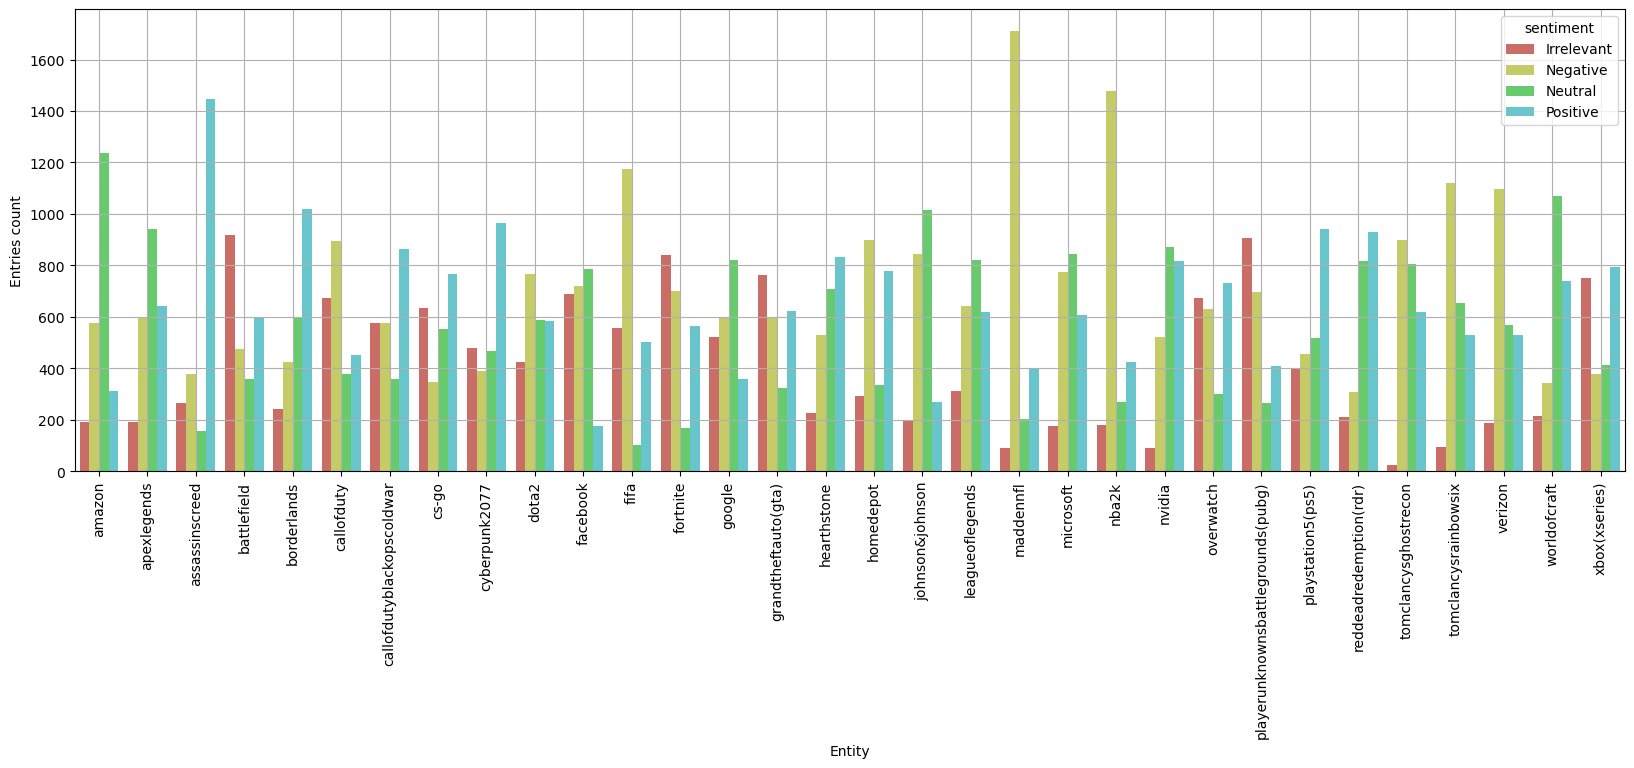

In [5]:
#plot entries by entities and sentiment

plot = train.groupby(by=['entity', 'sentiment']).count().reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(plot, x='entity', y='id', hue='sentiment')
plt.xticks(rotation=90)
plt.xlabel('Entity')
plt.ylabel('Entries count')
plt.grid()

In [6]:
stopwords = nltk.corpus.stopwords.words('english')

#n-gram model with nltk tokenizer
bow = CountVectorizer(
    tokenizer = word_tokenize,
    stop_words = stopwords,
    ngram_range = (1, 4),
)

In [7]:
train, test = train_test_split(train, test_size=0.2)

In [8]:
X_train_bow = bow.fit_transform(train.text)
X_test_bow = bow.transform(test.text)
X_val_bow = bow.transform(validation.text)

y_train_bow = train.sentiment
y_test_bow = test.sentiment
y_val_bow = validation.sentiment

In [9]:
#distribution of entries by sentiment
y_test_bow.value_counts() / y_test_bow.count()

Negative      0.301533
Positive      0.265448
Neutral       0.250854
Irrelevant    0.182165
Name: sentiment, dtype: float64

In [10]:
#fit and evaluate the model
model = LogisticRegression(solver='liblinear', max_iter=200)
model.fit(X_train_bow, y_train_bow)

test_preds = model.predict(X_test_bow)
print('Accuracy on test: {:.02f}%'.format(accuracy_score(y_test_bow, test_preds) * 100))

Accuracy on test: 88.94%


In [11]:
val_preds = model.predict(X_val_bow)
print('Accuracy on validation: {:.02f}%'.format(accuracy_score(y_val_bow, val_preds) * 100))

Accuracy on validation: 97.90%
